In [1]:
import wellmap
import pandas as pd
import os
import string
import seaborn as sns
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

New for multiple images in CP file

In [202]:
part_to_folder = r"C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-09-17 HEK SPH Multiple drug test"

# files = [f for f in listdir(part_to_folder) if isfile(join(part_to_folder, f))]

image_list_path = os.path.join(part_to_folder, "ExpImage.csv")
data_path  = os.path.join(part_to_folder, "ExpWells_plate.csv")

data_raw_df = pd.read_csv(data_path) 
image_list_df = pd.read_csv(image_list_path) 

print(image_list_df)


                                        FileName_RGB  ImageNumber
0  2024-09-16 multiple drugs plate 1 0H (Multicha...            1
1  2024-09-16 multiple drugs plate 1 24H (Multich...            2
2  2024-09-16 multiple drugs plate 2 0H (Multicha...            3
3  2024-09-16 multiple drugs plate 2 24H (Multich...            4


Extract wellmaps and combine into one df with names of the images

C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-09-17 HEK SPH Multiple drug test\2024-09-16 multiple drugs plate 1 0H (Multichannel).toml


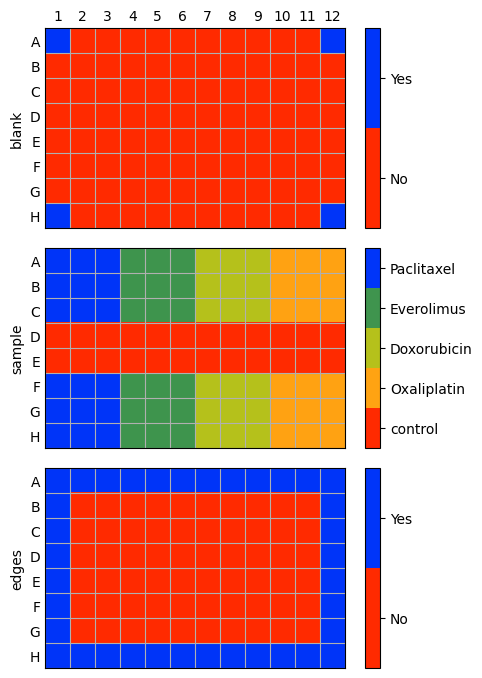

In [203]:
wellmap_path_list = []

for file in os.listdir(part_to_folder):
    if file.endswith(".toml"):
        wellmap_path_list.append(os.path.join(part_to_folder, file))
        # wellmap_path_list.append(file)

print(wellmap_path_list[0])

wellmap_df = wellmap.load(wellmap_path_list[0]) 

wellmap_list = []

for file in wellmap_path_list:
    wellmap_i = wellmap.load(file)
    wellmap_list.append(wellmap_i)

wellmaps_df = pd.concat(wellmap_list, axis=0, ignore_index=True)
# print(wellmaps_df)

wellmap.show(file);
plt.show();

Generating labels for wells

In [204]:
# row_column_df = pd.DataFrame(columns=['row','col'])

row =  list(string.ascii_uppercase[0:8])
column = list(range(1,13))
plate = image_list_df['FileName_RGB'].to_list()

row_column_list = []


for p in plate:
    for c in column:
        for r in row:
            array_i = [r,c]
            row_column_list.append(array_i)

row_column_df = pd.DataFrame(row_column_list, columns = ['row', 'col']) 

print(row_column_df)

    row  col
0     A    1
1     B    1
2     C    1
3     D    1
4     E    1
..   ..  ...
379   D   12
380   E   12
381   F   12
382   G   12
383   H   12

[384 rows x 2 columns]


Add images names to data (thank you CellProfiler for convenience)

In [205]:
data_full_df =  pd.merge(data_raw_df, image_list_df, on='ImageNumber') #Data with image names (FileName_RGB)
data_indexed = pd.concat([row_column_df, data_full_df], axis=1, join='inner') #Data with image names (FileName_RGB) and cell indexes (row,col)

data_indexed['col']=data_indexed['col'].astype(str) #Otherwise everything will break

data_plate = pd.merge(data_indexed, wellmaps_df, on=['FileName_RGB','row','col']) #Data with image names (FileName_RGB), cell indexes and wellmap
print(data_plate.columns)

Index(['row', 'col', 'ImageNumber', 'ObjectNumber',
       'Intensity_IntegratedIntensity_OrigGreen',
       'Intensity_IntegratedIntensity_OrigRed',
       'Intensity_MeanIntensity_OrigGreen', 'Intensity_MeanIntensity_OrigRed',
       'Intensity_StdIntensity_OrigGreen', 'Intensity_StdIntensity_OrigRed',
       'FileName_RGB', 'well', 'well0', 'row_i', 'col_j', 'blank', 'sample',
       'cells', 'uv', 'RZ_incubation', 'substance_incubation', 'culture_type',
       'concentration', 'plate_number', 'edges', 'control'],
      dtype='object')


In [182]:
cul_type_list = data_plate['culture_type'].unique()

data_plate_corrected = data_plate.iloc[:0,:].copy()  #Clone of plates df but empty

print(cul_type_list)

for c_type in cul_type_list:
    data_plate_i = data_plate[(data_plate['culture_type'] == c_type)]
    reference_plate = data_plate_i[(data_plate_i['RZ_incubation'] == 0)]
    sample_plate = data_plate_i[(data_plate_i['RZ_incubation'] != 0)]

    reference_plate = reference_plate.reset_index(drop=True)
    sample_plate = sample_plate.reset_index(drop=True)

    mean = reference_plate['Intensity_IntegratedIntensity_OrigGreen'].mean()
    
    reference_plate['Mean_dif'] = reference_plate['Intensity_MeanIntensity_OrigGreen']/mean

    sample_plate['Mean_corr'] = sample_plate['Intensity_MeanIntensity_OrigGreen']/reference_plate['Mean_dif'] 


    data_plate_corrected = data_plate_corrected.append(sample_plate)

print(data_plate_corrected)

['SPH']
    row col  ImageNumber  ObjectNumber  \
0     A   1            1             1   
1     B   1            1             2   
2     C   1            1             3   
3     D   1            1             4   
4     E   1            1             5   
..   ..  ..          ...           ...   
379   D  12            4            92   
380   E  12            4            93   
381   F  12            4            94   
382   G  12            4            95   
383   H  12            4            96   

     Intensity_IntegratedIntensity_OrigGreen  \
0                                  69.960787   
1                                  72.349023   
2                                  73.788238   
3                                  85.827455   
4                                  87.376474   
..                                       ...   
379                              1715.352992   
380                              1551.996134   
381                              1706.996128   
382    

C:\Users\Modern\AppData\Local\Temp\ipykernel_16492\3629538383.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_plate_corrected = data_plate_corrected.append(sample_plate)


In [190]:
sample_list = data_plate['sample'].unique()

data_plate_corrected = data_plate.iloc[:0,:].copy()  #Clone of plates df but empty

print(sample_list)

for sample in sample_list:
    data_plate_i = data_plate[(data_plate['sample'] == sample)]
    reference_plate = data_plate_i[(data_plate_i['RZ_incubation'] == '0H')]
    sample_plate = data_plate_i[(data_plate_i['RZ_incubation'] != '0H')]

    reference_plate = reference_plate.reset_index(drop=True)
    sample_plate = sample_plate.reset_index(drop=True)

    mean = reference_plate['Intensity_IntegratedIntensity_OrigGreen'].mean()
    
    reference_plate['Mean_dif'] = reference_plate['Intensity_MeanIntensity_OrigGreen']/mean

    sample_plate['Mean_corr'] = sample_plate['Intensity_MeanIntensity_OrigGreen']/reference_plate['Mean_dif'] 


    data_plate_corrected = data_plate_corrected.append(sample_plate)

print(data_plate_corrected)

['Topotecan' 'control' 'Docetaxel' 'Camptothecin' 'DMSO 10%' 'Paclitaxel'
 'Everolimus' 'Doxorubicin' 'Oxaliplatin']
   row col  ImageNumber  ObjectNumber  \
0    A   1            1             1   
1    B   1            1             2   
2    C   1            1             3   
3    F   1            1             6   
4    G   1            1             7   
..  ..  ..          ...           ...   
31   B  12            4            90   
32   C  12            4            91   
33   F  12            4            94   
34   G  12            4            95   
35   H  12            4            96   

    Intensity_IntegratedIntensity_OrigGreen  \
0                                 69.960787   
1                                 72.349023   
2                                 73.788238   
3                                 68.164708   
4                                 63.682355   
..                                      ...   
31                              1725.513776   
32            

C:\Users\Modern\AppData\Local\Temp\ipykernel_16492\62544821.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_plate_corrected = data_plate_corrected.append(sample_plate)
C:\Users\Modern\AppData\Local\Temp\ipykernel_16492\62544821.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_plate_corrected = data_plate_corrected.append(sample_plate)
C:\Users\Modern\AppData\Local\Temp\ipykernel_16492\62544821.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_plate_corrected = data_plate_corrected.append(sample_plate)
C:\Users\Modern\AppData\Local\Temp\ipykernel_16492\62544821.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

In [208]:
plate_list = data_plate['plate_number'].unique()

data_plate_corrected = data_plate.iloc[:0,:].copy()  #Clone of plates df but empty

print(plate_list)

for plate in plate_list:
    data_plate_i = data_plate[(data_plate['plate_number'] == plate)]

    print(data_plate_i)

    reference_plate = data_plate_i[(data_plate_i['RZ_incubation'] == '0')]
    sample_plate = data_plate_i[(data_plate_i['RZ_incubation'] != '0')]

    reference_plate = reference_plate.reset_index(drop=True)
    sample_plate = sample_plate.reset_index(drop=True)

    mean_green = reference_plate['Intensity_IntegratedIntensity_OrigGreen'].mean()
    mean_red = reference_plate['Intensity_IntegratedIntensity_OrigRed'].mean()

    # print(sample_plate['FileName_RGB'])


    
    reference_plate['Mean_dif_green'] = reference_plate['Intensity_MeanIntensity_OrigGreen']/mean

    sample_plate['Mean_corr_green'] = sample_plate['Intensity_MeanIntensity_OrigGreen']/reference_plate['Mean_dif_green'] 

    reference_plate['Mean_dif_red'] = reference_plate['Intensity_MeanIntensity_OrigRed']/mean

    sample_plate['Mean_corr_red'] = sample_plate['Intensity_MeanIntensity_OrigRed']/reference_plate['Mean_dif_red'] 


    data_plate_corrected = data_plate_corrected.append(sample_plate)

# print(data_plate_corrected)

[1 2]
    row col  ImageNumber  ObjectNumber  \
0     A   1            1             1   
1     B   1            1             2   
2     C   1            1             3   
3     D   1            1             4   
4     E   1            1             5   
..   ..  ..          ...           ...   
187   D  12            2            92   
188   E  12            2            93   
189   F  12            2            94   
190   G  12            2            95   
191   H  12            2            96   

     Intensity_IntegratedIntensity_OrigGreen  \
0                                  69.960787   
1                                  72.349023   
2                                  73.788238   
3                                  85.827455   
4                                  87.376474   
..                                       ...   
187                              1527.129466   
188                              1562.207898   
189                              1227.690222   
190      

C:\Users\Modern\AppData\Local\Temp\ipykernel_16492\2399583556.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_plate_corrected = data_plate_corrected.append(sample_plate)
C:\Users\Modern\AppData\Local\Temp\ipykernel_16492\2399583556.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_plate_corrected = data_plate_corrected.append(sample_plate)


In [186]:
blank_array = []

plate_list = data_plate_corrected['FileName_RGB'].unique()
print(plate_list)

for p in plate_list:
    blank_p = data_plate_corrected[(data_plate_corrected['blank'] == 'Yes') & 
                                   (data_plate_corrected['FileName_RGB'] == p)].loc[:,'Mean_corr_green'].mean()
    
    blank_std_p = data_plate_corrected[(data_plate_corrected['blank'] == 'Yes') 
                                       & (data_plate_corrected['FileName_RGB'] == p)].loc[:,'Mean_corr_green'].std()

    bc_array_i = [blank_p, blank_std_p ,p]

    print(bc_array_i)

    blank_array.append(bc_array_i)

    blank_df = pd.DataFrame(blank_array, columns = ['blank_mean','blank_std','FileName_RGB']) 

data_plate_with_blank_values = pd.merge(data_plate_corrected, blank_df, on=['FileName_RGB'])



['2024-09-16 multiple drugs plate 1 24H (Multichannel).tif'
 '2024-09-16 multiple drugs plate 2 24H (Multichannel).tif']
[nan, nan, '2024-09-16 multiple drugs plate 1 24H (Multichannel).tif']
[nan, nan, '2024-09-16 multiple drugs plate 2 24H (Multichannel).tif']


In [172]:
data_plate_with_blank_values['Green_blanked'] = data_plate_with_blank_values['Mean_corr_green'] - data_plate_with_blank_values['blank_mean']

data_plate_wo_blank = data_plate_with_blank_values[data_plate_with_blank_values.blank == 'No'].copy() #dataframe without blank

f = '2024-08-16 RZ RD Chlorambucil 3H (Multichannel).tif'

for f in plate_list:
    control_p = data_plate_wo_blank[(data_plate_wo_blank['control'] == 'Yes') & 
                                    (data_plate_wo_blank['FileName_RGB'] == p)].loc[:,'Green_blanked'].mean()
    




In [187]:
data_plate_with_blank_values['Green_blanked'] = data_plate_with_blank_values['Mean_corr_green'] - data_plate_with_blank_values['blank_mean']

data_plate_wo_blank = data_plate_with_blank_values[data_plate_with_blank_values.blank == 'No'].copy() #dataframe without blank

control_array = []

for p in plate_list:
    control_p = data_plate_wo_blank[(data_plate_wo_blank['control'] == 'Yes') & 
                                    (data_plate_wo_blank['FileName_RGB'] == p)].loc[:,'Green_blanked'].mean()

    control_std_p = data_plate_wo_blank[(data_plate_wo_blank['control'] == 'Yes') & 
                                        (data_plate_wo_blank['FileName_RGB'] == p)].loc[:,'Green_blanked'].std()
    

    ctr_array_i = [control_p, control_std_p ,p]


    control_array.append(ctr_array_i)

    control_df = pd.DataFrame(control_array, columns = ['control_mean','control_std','FileName_RGB']) 

print(control_df)

data_plate_with_control = pd.merge(data_plate_wo_blank, control_df, on=['FileName_RGB'])

data_plate_with_control['Green_relative'] = data_plate_with_control['Green_blanked']/data_plate_with_control['control_mean']*100

print(data_plate_with_control['Green_relative'])



   control_mean  control_std  \
0           NaN          NaN   
1           NaN          NaN   

                                        FileName_RGB  
0  2024-09-16 multiple drugs plate 1 24H (Multich...  
1  2024-09-16 multiple drugs plate 2 24H (Multich...  
0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
179   NaN
180   NaN
181   NaN
182   NaN
183   NaN
Name: Green_relative, Length: 184, dtype: float64


In [ ]:
ax = sns.relplot(data=data_plate_with_control, x="conc_uM", y="Green_relative",  kind="line")

ax.set(xscale="symlog")

ax.set(xlim=(0, 500),ylim = (0,120))

ax.set(xlabel='Concentration, uM', ylabel='Cell viability relative to control, %')

plt.show()


In [ ]:
ax = sns.relplot(data=data_plate_with_control, x="conc_pc", y="Green_relative", hue = 'culture_type',  kind="line")

# ax.set(xscale="symlog")

# ax.set(xlim=(0, 10),ylim = (0,120))

ax.set(xlabel='Concentration, pc', ylabel='Cell viability relative to control, %')

plt.show()

In [ ]:
ax = sns.boxplot(data=data_plate_with_control, x="conc_uM", y="Green_relative", hue = 'sample')


ax.set(xlim=(-1, None),ylim = (0,130))

In [76]:
# q_low = data_plate_with_control["Green_relative"].quantile(0.01)
# q_hi  = data_plate_with_control["Green_relative"].quantile(0.99)

# print(q_low, q_hi)



59.03067513802207 142.48789217054778


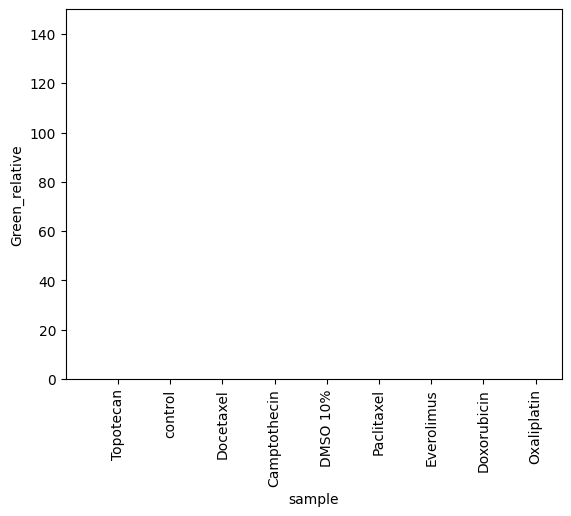

In [174]:
ax = sns.boxplot(data=data_plate_with_control, x="sample", y="Green_relative")
# ax = sns.swarmplot(data=data_plate_with_control, x="sample", y="Green_relative")

ax.set(xlim=(-1, None),ylim = (0,150))
ax.tick_params(axis='x', rotation=90)

[(-1.0, 11.5), (0.0, 121.66409551395154)]

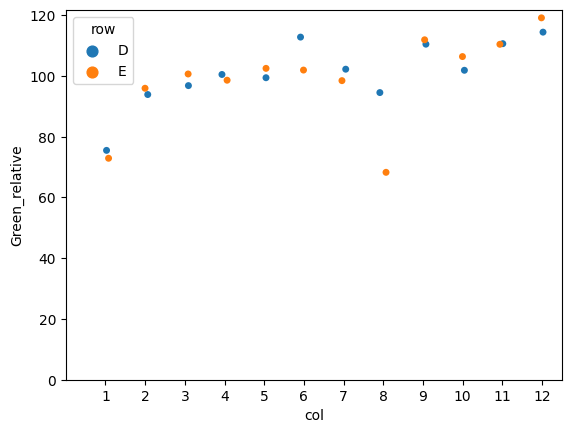

In [148]:
selected_data = data_plate_with_control[(data_plate_with_control['sample'] == 'control') & 
                                        (data_plate_with_control['plate_number'] == 2)]

ax = sns.stripplot(data=selected_data, x="col", y="Green_relative", hue='row')
ax.set(xlim=(-1, None),ylim = (0,None))

C:\Users\Modern\AppData\Local\Temp\ipykernel_16492\650358872.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['col'] = pd.Categorical(selected_data['col'], categories=['1', '2', '3', '4','5', '6', '7', '8','9', '10', '11', '12'])


<Axes: xlabel='col', ylabel='row'>

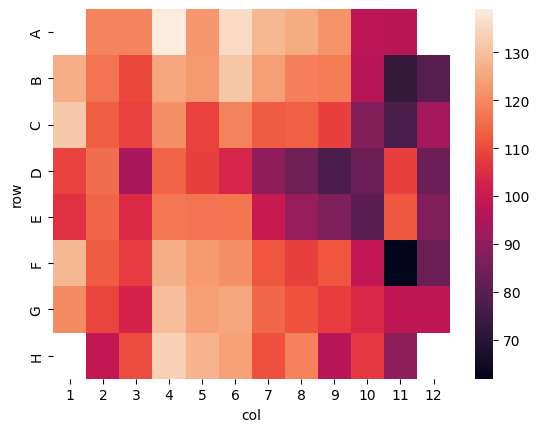

In [162]:
selected_data = data_plate_with_control[(data_plate_with_control['plate_number'] == 1)]

selected_data['col'] = pd.Categorical(selected_data['col'], categories=['1', '2', '3', '4','5', '6', '7', '8','9', '10', '11', '12'])
df = selected_data.sort_values('col')


glue = selected_data.pivot(index="row", columns="col", values="Green_relative")
sns.heatmap(glue)


In [67]:
ax = sns.boxplot(data=data_plate_with_control, x="conc_pc", y="Green_relative", hue = 'culture_type')


ax.set(xlim=(-1, None),ylim = (0,130))

ValueError: Could not interpret input 'conc_pc'

In [ ]:
data_selected = data_plate_with_control[data_plate_with_control['sample'] == 'GA-705 preUV']

ax = sns.boxplot(data=data_selected, x="conc_uM", y="Green_relative", hue = 'culture_type')

In [ ]:
file_name = part_to_folder + '/data_processed.csv'

data_plate_with_control.to_csv(file_name)